[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/WoWED-volcano/blob/main/het_vel_notebook.ipynb)

In [ ]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/WoWVED tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -7 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [1]:
import time

import xarray as xr
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('helpers/mplstyle.mplstyle')

In [35]:
from helpers.volcano_data_helpers import (
    get_volcano_data,
    fetch_topography_data,
    construct_highly_opinionated_prior
    )

from helpers.plotting_helpers import (
    plot_topography,
    plot_prior_model,
    plot_design_space_dict,
    plot_design,
    draw_bounding_box,
    plot_design_statistics
    )

In [3]:
##################### Choose the volcano ##################### 
VOLCANO_NAME = 'Etna'
###################### Get the data ##  #######################
VOLCANO_DATA = get_volcano_data(VOLCANO_NAME)

################# Choose area of interest ####################
# BOUNDING_BOX = dict(
#     min_lon= VOLCANO_DATA['lon'] - 0.15, # in deg lon
#     max_lon= VOLCANO_DATA['lon'] + 0.15, # in deg lon
#     min_lat= VOLCANO_DATA['lat'] - 0.15, # in deg lat
#     max_lat= VOLCANO_DATA['lat'] + 0.15, # in deg lat
# )
BOUNDING_BOX = dict(
    extent_south = 20.0, # in km
    extent_north = 20.0, # in km
    extent_west  = 20.0, # in km
    extent_east  = 20.0, # in km
)
# the function below allows you to interactively choose the bounding box
# NOTE: the first rectangle you draw will be used as the bounding box, in doubt rerun the cell and try again
# WARNING: even after running other cells, the BOUNDING_BOX variable will still be updated if changed in the map
m, BOUNDING_BOX = draw_bounding_box(VOLCANO_DATA, BOUNDING_BOX)
display(m)

################# Choose the depth range ####################
MAX_DEPTH = 10.0        # km below sea level


Map(center=[37.748, 14.999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [4]:
# reduce the resolution of the topography data to keep lookup table low in memory
cells_hor = 128
cells_ver = 256

In [5]:
try:
    with open('.opentopography.txt', 'r') as file:
        api_key = file.read()
except FileNotFoundError:
    api_key = 'demoapikeyot2022'
    # This is a demo key which should work for a limited number of requests. If you want to use the API more frequently, or if the key stops working, you can get your own key (see https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets for more information).

# API key for the Open Topography API to fetch the digital elevation model
# API key is stored in a separate file .opentopography.txt to avoid accidentally sharing it on GitHub

SURFACE_DATA = fetch_topography_data(
    VOLCANO_DATA, BOUNDING_BOX, api_key=api_key,
    cells_E=cells_hor, cells_N=cells_hor)

Fetching topography data for SRTM15Plus between 37.56751 and 37.92804 latitude and 14.77253 and 15.22657 longitude
Data loaded from cache


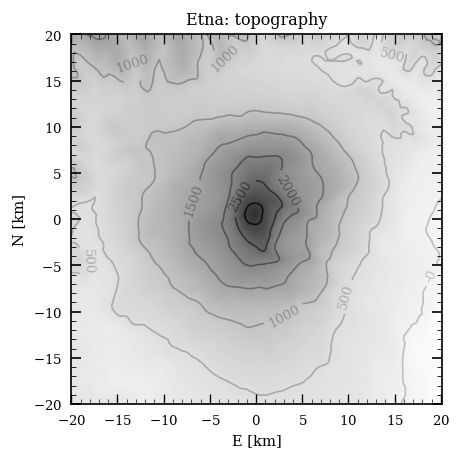

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
plot_topography(ax, SURFACE_DATA['topography'])
ax.set_title(f'{VOLCANO_NAME}: topography')
plt.show()

# Prior Information

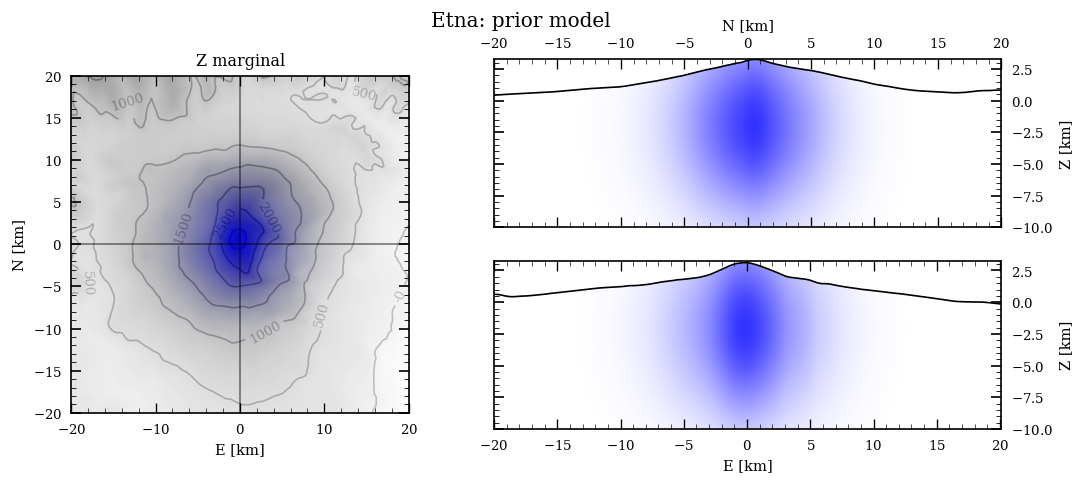

In [7]:
PRIOR_DATA = construct_highly_opinionated_prior(
    SURFACE_DATA, MAX_DEPTH,
    center_location    = (0.0, 0.0, -2.0), # km
    standard_deviation = (5.0, 5.0,  5.0), # km  
    prop2elevation     = True
)

%matplotlib inline
fig, ax_dict = plot_prior_model(PRIOR_DATA, SURFACE_DATA, VOLCANO_DATA)
fig.suptitle(f'{VOLCANO_DATA["Volcano Name"]}: prior model', fontsize=12)

plt.show()

In [8]:
from helpers.experimental_design_helpers import get_prior_samples

N_precomputed = int(1e3)
prior_samples = get_prior_samples(
    PRIOR_DATA, N_precomputed)

In [9]:
# add buffer of two cells to avoid edge effects
dE = PRIOR_DATA.E[1] - PRIOR_DATA.E[0]
dN = PRIOR_DATA.N[1] - PRIOR_DATA.N[0]
dZ = PRIOR_DATA.Z[1] - PRIOR_DATA.Z[0]

padded_E = np.pad(
    PRIOR_DATA.E.values, 5, mode='linear_ramp',
    end_values=(PRIOR_DATA.E.values[0] - 5 * dE, PRIOR_DATA.E.values[-1] + 5 * dE))
padded_N = np.pad(
    PRIOR_DATA.N.values, 5, mode='linear_ramp',
    end_values=(PRIOR_DATA.N.values[0] - 5 * dN, PRIOR_DATA.N.values[-1] + 5 * dN))
padded_Z = np.pad(
    PRIOR_DATA.Z.values, 5, mode='linear_ramp',
    end_values=(PRIOR_DATA.Z.values[0] - 5 * dZ, PRIOR_DATA.Z.values[-1] + 5 * dZ))

velocity_model = xr.DataArray(
    np.zeros_like(PRIOR_DATA.values),
    dims=('E', 'N', 'Z'),
    coords=dict(
        N=PRIOR_DATA.N,
        E=PRIOR_DATA.E,
        Z=PRIOR_DATA.Z
    ))

dZ = (PRIOR_DATA.Z[1] - PRIOR_DATA.Z[0]).values

def velocity_profile(depth):
    vel = np.ones_like(depth) * 3500.0
    
    # Chiarabba2000-bp, Villasenor1998-mp
    # 1.83    1082.8
    # 5.90    3164.4
    # 9.63    4271.3
    # 15.73   4692.5
    # 21.70   5462.5
    # 34.73   6136.3
    
    vel[ depth > -34.73 * 1e3] = 6136.3
    vel[(depth > -34.73 * 1e3) & (depth <= -21.70*1e3 )] = 6136.3
    vel[(depth > -21.70 * 1e3) & (depth <= -15.73*1e3 )] = 5462.5
    vel[(depth > -15.73 * 1e3) & (depth <= -9.63*1e3  )] = 4692.5
    vel[(depth > -9.63  * 1e3) & (depth <= -5.90*1e3  )] = 4271.3
    vel[(depth > -5.90  * 1e3) & (depth <= -1.83*1e3  )] = 3164.4
    
    vel[depth > -1.83  * 1e3] = 1082.8    
    return vel

for i_z, z in enumerate(PRIOR_DATA.Z.values):
    depth = z - SURFACE_DATA['topography'].values    
    velocity_model[:, :, i_z] = velocity_profile(depth)
    

velocity_model = xr.DataArray(
    np.pad(velocity_model.values, 5, mode='edge'),
    dims=('E', 'N', 'Z'),
    coords=dict(
        N=padded_N,
        E=padded_E,
        Z=padded_Z
    ))

# gaussian filter to smooth the layered velocity model used as a background model
from scipy.ndimage import gaussian_filter

velocity_model = xr.DataArray(
    gaussian_filter(velocity_model.values, sigma=10),
    # velocity_model.values,
    dims=('E', 'N', 'Z'),
    coords=dict(
        N=padded_N,
        E=padded_E,
        Z=padded_Z,
    ))

# add long wavelength structure noise
from scipy.signal import fftconvolve
correlation_scale = 3000e3

E, N, Z = np.meshgrid(velocity_model.E, velocity_model.N, velocity_model.Z)
dist = np.sqrt(E**2 + N **2 + Z**2)

np.random.seed(0)
noise = np.random.normal(0, 1, size=velocity_model.shape)
filter_kernel = np.exp(-dist**2/(2*correlation_scale))

noise = fftconvolve(noise, filter_kernel, mode='same')

velocity_model *= (1 + 0.5 * noise/(abs(noise)).max())

# another gaussian filter with smaller sigma to have no sharp edges
velocity_model = xr.DataArray(
    gaussian_filter(velocity_model.values, sigma=2),
    dims=('E', 'N', 'Z'),
    coords=dict(
        N=padded_N,
        E=padded_E,
        Z=padded_Z,
    ))

def set_air_velocity(depth, vel):
    # dZ*5 is the buffer zone to make sure vertical gradient is always calculated within the subsurface
    vel[ depth > dZ*5           ] = 330.0
    return vel

for i_z, z in enumerate(velocity_model.Z.values):
    depth = z - np.pad(SURFACE_DATA['topography'].values, 5, mode='edge')
    velocity_model[:, :, i_z] = set_air_velocity(depth, velocity_model[:, :, i_z].values)

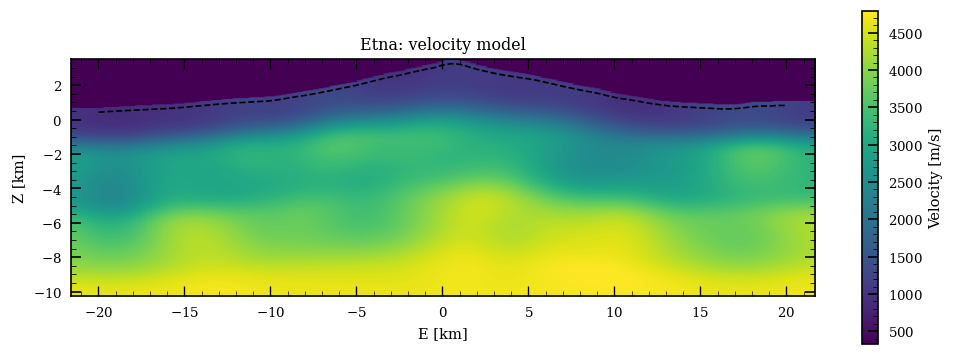

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

vel_im = velocity_model.copy()
# vel_im.values[vel_im.values < 340.0] = np.nan

im = ax.imshow(
    vel_im.sel(E=0, method='nearest').values.T,
    extent=(
        vel_im.E.min()*1e-3, vel_im.E.max()*1e-3,
        vel_im.Z.min()*1e-3, vel_im.Z.max()*1e-3
    ),
    origin='lower',
    cmap='viridis'
)

ax.set_title(f'{VOLCANO_NAME}: velocity model')

plt.colorbar(im, ax=ax, label='Velocity [m/s]', orientation='vertical', shrink=0.6)

ax.plot(
    SURFACE_DATA.N.values * 1e-3,
    SURFACE_DATA['topography'].interp(E=0, method='nearest').values * 1e-3,
    'k--', lw=1)

ax.set_xlabel('E [km]')
ax.set_ylabel('Z [km]')

ax.set_aspect('equal')

plt.show()

# Eikonal Solver

In [11]:
import pykonal

class Pykonal_Forward:
    def __init__(
        self, x, y, z, seismic_grid,
        return_gradient=False,
        return_raylength=False
    ):
        
        
        self.x_min, self.x_max, self.x_N = x.min(), x.max(), x.size
        self.y_min, self.y_max, self.y_N = y.min(), y.max(), y.size
        self.z_min, self.z_max, self.z_N = z.min(), z.max(), z.size      

        self.dx = (self.x_max - self.x_min) / self.x_N
        self.dy = (self.y_max - self.y_min) / self.y_N
        self.dz = (self.z_max - self.z_min) / self.z_N
                
        self.seismic_grid = seismic_grid
        
        self.return_gradient = return_gradient
        self.return_raylength = return_raylength
        
    def __call__(self, source_coords, receiver_coords):
        '''
        Pykonal is a bit temperamental at times so thats why the input is scaled by 1e-3 and shifted to avoid numerical issues.
        '''
        
        scaling = 1e-3
        shift_x = self.x_min*scaling
        shift_y = self.y_min*scaling
        shift_z = self.z_min*scaling
        
        source_coords = source_coords.astype(np.float64)
        source_coords *= scaling
        source_coords[0] -= shift_x
        source_coords[1] -= shift_y
        source_coords[2] -= shift_z
        
        receiver_coords = receiver_coords.astype(np.float64)
        receiver_coords *= scaling
        receiver_coords[:,0] -= shift_x
        receiver_coords[:,1] -= shift_y
        receiver_coords[:,2] -= shift_z
        
        solver = pykonal.solver.PointSourceSolver()
        solver.velocity.min_coords     = (
            self.x_min*scaling - shift_x,
            self.y_min*scaling - shift_y,
            self.z_min*scaling - shift_z
        )
        solver.velocity.node_intervals = self.dx*scaling, self.dy*scaling, self.dz*scaling
        solver.velocity.npts           = self.x_N, self.y_N, self.z_N
        solver.velocity.values         = self.seismic_grid.values * scaling
        
        solver.src_loc = source_coords
            
        solver.solve()
        
        tt = solver.traveltime.resample(receiver_coords)
        
        if self.return_gradient or self.return_raylength:
            out = [tt[..., None],]
        
        if self.return_gradient:
            grad_grid = solver.traveltime.gradient.values        
            grad_out = np.zeros((receiver_coords.shape[0], 3))
            
            for dim in range(3):
            
                grad = xr.DataArray(
                    grad_grid[...,dim],
                    dims=('E', 'N', 'Z'),
                    coords=dict(
                        N=self.seismic_grid.N * scaling - shift_x,
                        E=self.seismic_grid.E * scaling - shift_y,
                        Z=self.seismic_grid.Z * scaling - shift_z,
                    )
                )
            
                grad = grad.interp(
                    E=xr.DataArray(receiver_coords[:,0], dims='dim'),
                    N=xr.DataArray(receiver_coords[:,1], dims='dim'),
                    Z=xr.DataArray(receiver_coords[:,2], dims='dim'),
                    method='linear')

                
                grad_out[:,dim] = grad.values
                
                
                
            out.append(grad_out)
        
        if self.return_raylength:
            raylength = []
            
            # for i in tqdm(range(receiver_coords.shape[0]), disable=True):
            #     ray = solver.trace_ray(receiver_coords[i])
            #     rl = np.sum(np.sqrt(np.sum(np.diff(ray, axis=0)**2, axis=1)))*(1/scaling)
            #     raylength.append(rl)
            
            def parallel_raylength(i):
                ray = solver.trace_ray(receiver_coords[i])
                rl = np.sum(np.sqrt(np.sum(np.diff(ray, axis=0)**2, axis=1)))*(1/scaling)
                return rl
            
            from mpire import WorkerPool
            
            with WorkerPool(n_jobs=10) as p:
                raylength = p.map(parallel_raylength, range(receiver_coords.shape[0]), progress_bar=False)
                            
            out.append(np.array(raylength)[..., None])

        if len(out) == 1:
            return out[0]

        return out


pyk_forward = Pykonal_Forward(
    x = velocity_model.E.values,
    y = velocity_model.N.values,
    z = velocity_model.Z.values,
    seismic_grid = velocity_model, 
    return_gradient=True,
    return_raylength=False # quite expensive
)

# data_test = pyk_forward(
#     prior_samples[5],
#     receiver_locations[:10],
# )

In [12]:
################# Calculate Prior Information ################

E_design = PRIOR_DATA.E
N_design = PRIOR_DATA.N 

receiver_locations_hor = np.meshgrid(
    E_design, N_design, indexing='ij')

receiver_locations_hor = np.stack(
    (receiver_locations_hor[0].ravel(), receiver_locations_hor[1].ravel()),
    axis=1)

receiver_locations_vert = SURFACE_DATA['topography'].interp(
    E=xr.DataArray(receiver_locations_hor[:,0], dims='dim'),
    N=xr.DataArray(receiver_locations_hor[:,1], dims='dim'),
    method='linear').values

receiver_locations = np.stack(
    (receiver_locations_hor[:,0], receiver_locations_hor[:,1], receiver_locations_vert),
    axis=1)

In [13]:
import os

lookup_filename = f'data/heterogeneous_vel/het_lookup_no_rlen_hor_{cells_hor}_{cells_ver}_surface_buffer.nc'
    
if not os.path.exists(lookup_filename):
    data_lookup = xr.Dataset(
        {'arrival_p':
            xr.DataArray(
                np.zeros((N_precomputed, E_design.size, N_design.size)), 
                dims=('m_sample', 'E', 'N'),
                coords=dict(
                    m_sample=np.arange(N_precomputed),
                    N=N_design,
                    E=E_design
                )
            ),
            'grad_x':
            xr.DataArray(
                np.zeros((N_precomputed, E_design.size, N_design.size)), 
                dims=('m_sample', 'E', 'N'),
                coords=dict(
                    m_sample=np.arange(N_precomputed),
                    N=N_design,
                    E=E_design
                )
            ),
            'grad_y':
            xr.DataArray(
                np.zeros((N_precomputed, E_design.size, N_design.size)), 
                dims=('m_sample', 'E', 'N'),
                coords=dict(
                    m_sample=np.arange(N_precomputed),
                    N=N_design,
                    E=E_design
                )
            ),
            'grad_z':
            xr.DataArray(
                np.zeros((N_precomputed, E_design.size, N_design.size)), 
                dims=('m_sample', 'E', 'N'),
                coords=dict(
                    m_sample=np.arange(N_precomputed),
                    N=N_design,
                    E=E_design
                )
            )
        }
    )
    from mpire import WorkerPool    
    def parallel_func(m_sample):
        return pyk_forward(
            m_sample[0],
            receiver_locations,
        )

    with WorkerPool(n_jobs=5) as p:
        results = p.map(
           parallel_func, prior_samples,
           progress_bar=True,
           chunk_size=1,
           concatenate_numpy_output=False)

    # results = []
    # for i in tqdm(range(N_precomputed)):
    #     results.append(pyk_forward(
    #         prior_samples[i],
    #         receiver_locations,
    #     ))

        
    for i in range(N_precomputed):
        data_lookup['arrival_p'][i] = results[i][0].reshape(E_design.size, N_design.size)
        data_lookup['grad_x'][i] = results[i][1][:,0].reshape(E_design.size, N_design.size)
        data_lookup['grad_y'][i] = results[i][1][:,1].reshape(E_design.size, N_design.size)
        data_lookup['grad_z'][i] = results[i][1][:,2].reshape(E_design.size, N_design.size)
    
                
    data_lookup.to_netcdf(lookup_filename, engine='netcdf4', format='NETCDF4')
    
else:
    data_lookup = xr.open_dataset(lookup_filename, engine='netcdf4', format='NETCDF4')

    print(f'Memory usage: {3*data_lookup.nbytes / 1e9:.2f} GB')
    
# drop_na_indices = data_lookup.isnull().any(dim=('datatype', 'E', 'N')).values   

# data_lookup = data_lookup.sel(m_sample=~drop_na_indices)

prior_samples = get_prior_samples(
    PRIOR_DATA, N_precomputed) # uses a set seed internally

# prior_samples = prior_samples[~drop_na_indices]

Memory usage: 1.57 GB


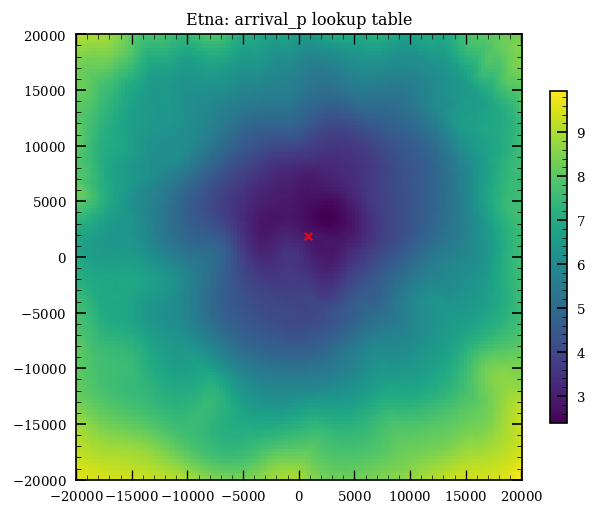

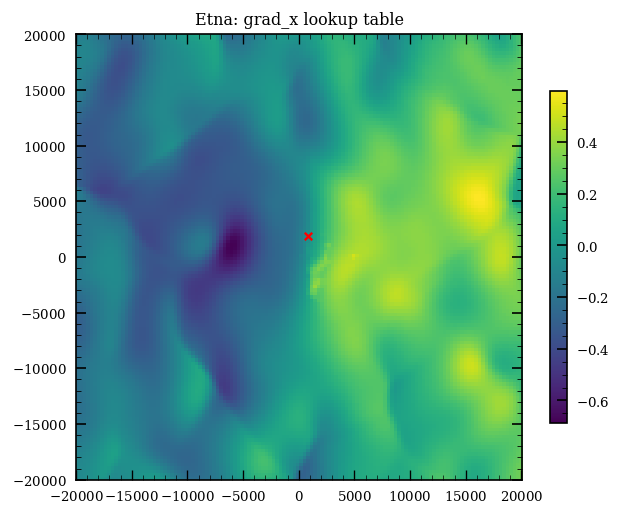

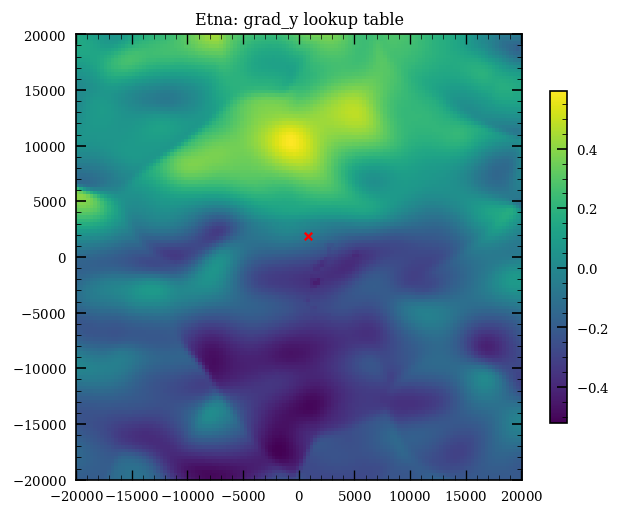

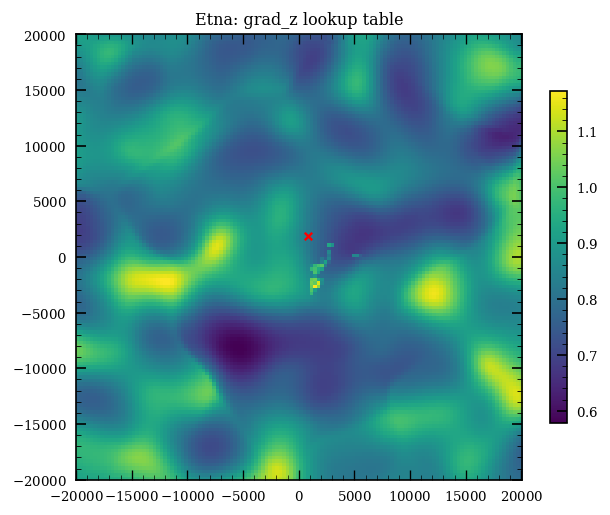

In [38]:
prior_i = 2

for dtype in ['arrival_p', 'grad_x', 'grad_y', 'grad_z']:
    fig, ax = plt.subplots(figsize=(6, 6), dpi=120)

    im = ax.imshow(
        data_lookup[dtype][prior_i].values.T,
        extent=(
            SURFACE_DATA['E'].min(), SURFACE_DATA['E'].max(),
            SURFACE_DATA['N'].min(), SURFACE_DATA['N'].max()
        ),
        origin='lower',
        cmap='viridis'
    )
    
    plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.6)

    # ax.scatter(
    #     receiver_locations[:,0],
    #     receiver_locations[:,1],
    #     c='k', s=0.5, label='receiver locations', marker='+'
    # )
    ax.scatter(
        prior_samples[prior_i,0],
        prior_samples[prior_i,1],
        c='r', s=20, label='source location', marker='x'
    )

    ax.set_title(f'{VOLCANO_NAME}: {dtype} lookup table')

    plt.show()

In [41]:
baz = np.rad2deg(np.arctan2(
    data_lookup['grad_y'][prior_i].values,
    data_lookup['grad_x'][prior_i].values))
    
incidence_angle = 90 - np.rad2deg(np.arcsin(
    data_lookup['grad_z'][prior_i].values / np.sqrt(
        data_lookup['grad_x'][prior_i].values**2 +
        data_lookup['grad_y'][prior_i].values**2 +
        data_lookup['grad_z'][prior_i].values**2
    )
))

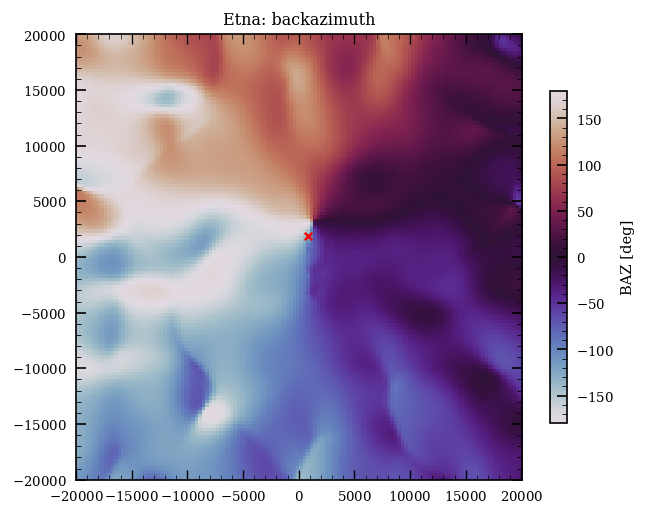

In [42]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)

im = ax.imshow(
    baz.T,
    extent=(
        SURFACE_DATA['E'].min(), SURFACE_DATA['E'].max(),
        SURFACE_DATA['N'].min(), SURFACE_DATA['N'].max()
    ),
    origin='lower',
    cmap='twilight'
)

plt.colorbar(im, ax=ax, label='BAZ [deg]', orientation='vertical', shrink=0.6)

ax.scatter(
    prior_samples[prior_i,0],
    prior_samples[prior_i,1],
    c='r', s=20, label='source location', marker='x'
)

ax.set_title(f'{VOLCANO_NAME}: backazimuth')

plt.show()

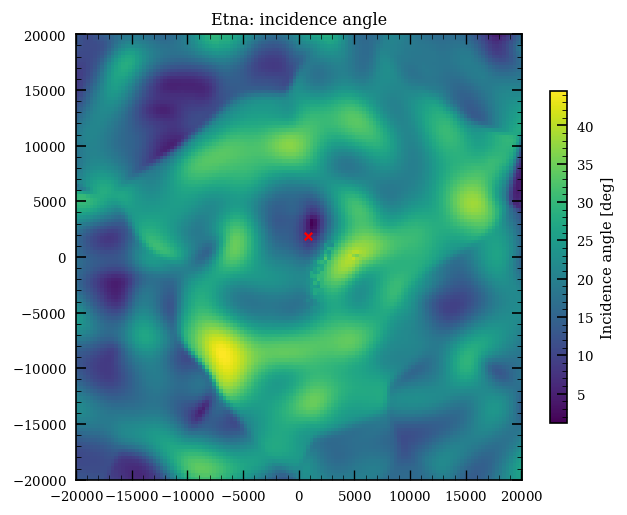

In [43]:

fig, ax = plt.subplots(figsize=(6, 6), dpi=120)

im = ax.imshow(
    incidence_angle.T,
    extent=(
        SURFACE_DATA['E'].min(), SURFACE_DATA['E'].max(),
        SURFACE_DATA['N'].min(), SURFACE_DATA['N'].max()
    ),
    origin='lower',
    cmap='viridis'
)

ax.scatter(
    prior_samples[prior_i,0],
    prior_samples[prior_i,1],
    c='r', s=20, label='source location', marker='x'
)

plt.colorbar(im, ax=ax, label='Incidence angle [deg]', orientation='vertical', shrink=0.6)

ax.set_title(f'{VOLCANO_NAME}: incidence angle')

plt.show()


In [20]:
from helpers.forward_function_helpers import Forward_Function

forward_function = Forward_Function({
    'arrival_p': {
        'std_obs' : 0.01,    # standard deviation due to observational uncertainty
        'std_vel' : 0.1,     # standard deviation due to uncertainty in the velocity model
    },
    'array': {
        'std_baz' : 6.0,     # degrees
        # 'std_inc' : 20.0,     # degrees
        'deg_std' : True,
        'baz_only': True,
        'correct_for_topography': True,
    },},
    data_lookup =data_lookup,
    surface_data=SURFACE_DATA,
    prior_samples=prior_samples,
)

test_design = [
    [['arrival_p'],                         np.array([0.0, 0.0, 0.0])*1e3,],
    [['array'],                             np.array([2.0, 0.0, 0.0])*1e3,],
    [['arrival_p', 'array'], np.array([4.0, 0.0, 0.0])*1e3,],
]

(5, 6) (5, 6)


In [23]:
################# Calculate Prior Information ################
from helpers.volcano_data_helpers import calculate_prior_information

prior_information = calculate_prior_information(
    PRIOR_DATA
)
print(f"Prior information: {prior_information:.2f} nats")
# this value in itself is not very informative, but we will make it more informative later on

Prior information: -28.85 nats


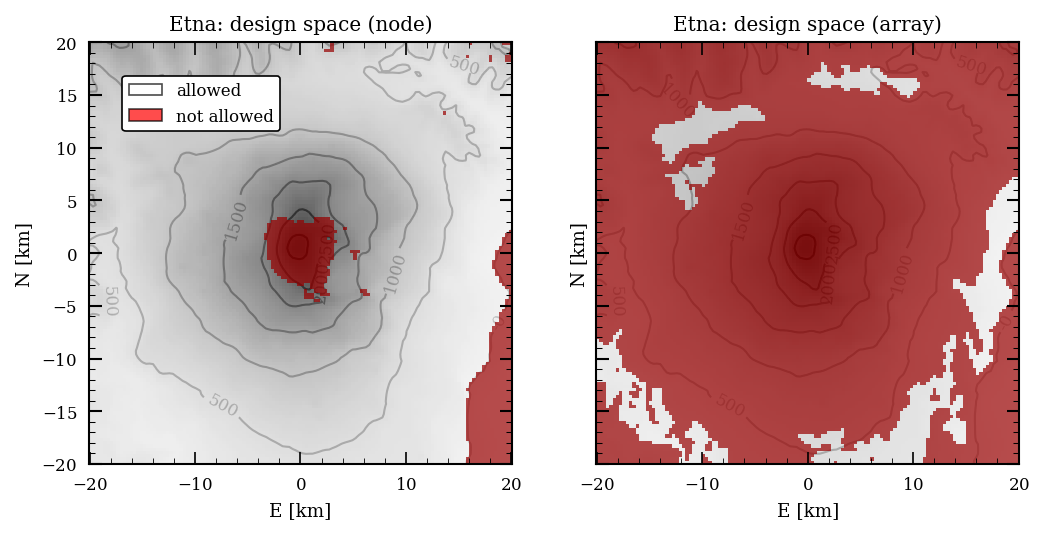

In [24]:
from helpers.design_space_helpers import construct_design_space

design_space_node = construct_design_space(
    SURFACE_DATA,
    max_incline             = 20.0,      # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0, # km
    )

design_space_array = construct_design_space(
    SURFACE_DATA,
    max_incline             = 3.0,         # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0,  # km,
    min_area                = 10           # km^2 minimum area of the connected region
    )

design_space_dict = dict(
    node=design_space_node,
    array=design_space_array,
)

%matplotlib inline
plot_design_space_dict(design_space_dict, SURFACE_DATA, VOLCANO_DATA);

In [25]:
from helpers.experimental_design_helpers import (
    DN_method,
    NMC_method)

dn_method = DN_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3)
)

nmc_method = NMC_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3),
)

GA progress:   0%|          | 0/5 [00:00<?, ?it/s, EIG=0]

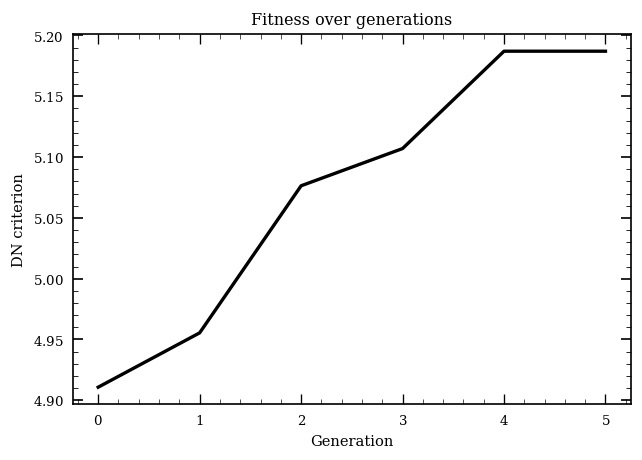

In [27]:
%matplotlib inline
from helpers.experimental_design_helpers import Design_Optimisation

# available_stations = dict(
#     n_node=3,
#     n_array=1)
available_stations = (
    ('array', 'arrival_p'),
    ('arrival_p',),
    ('arrival_p',),
    ('arrival_p',))     

design_optimisation = Design_Optimisation(
    nmc_method,
    SURFACE_DATA,
    design_space_dict,
)

best_design, info = design_optimisation.get_optimal_design(
    available_stations=available_stations,
        optimisation_algorithm='genetic',
        optimisation_kwargs=dict(
            num_generations=5,
            num_parents_mating=4,                                               
            plot_fitness=True,          
            random_seed=0,
        )
)

In [32]:
from helpers.plotting_helpers import interactive_design_plot

fig, updated_design, synthetic_true_model = interactive_design_plot(
    original_design   = best_design,
    volcano_data      = VOLCANO_DATA,
    surface_data      = SURFACE_DATA,
    prior_data        = PRIOR_DATA,
    design_space_dict = design_space_dict,
    eig_criterion     = nmc_method,
    prior_information = prior_information,
    forward_function  = forward_function,
    posterior         = False,
)

# ======================== INTERACTIVE PLOT ========================

# The plot above shows the optimal design. You can interact with it by moving the stations or the test source location around.
# The design is updated in real time and the design statistics are shown in the top right corner.

# ======================== Careful: ========================
# The design statistics might update with a delay, especially on an older computer or if running in google colab.
# When changing the design to quick the statistics might not update at all. Just reset by running the cell again.
# If a smooth experience is needed, run the code locally in a jupyter notebook. On my laptop the process is smooth and the statistics update in near real time.

# Sometimes it does not quite work and you have to run the cell again, change the design and then run the next cell manually.

display(fig)

Figure(axes=[Axis(label='E [km]', scale=LinearScale(max=20.0968359375, min=-20.0), side='bottom'), Axis(label=…

In [33]:
# make below cell work if interactive plot is not used
try:
    updated_design
except NameError:
    updated_design = best_design

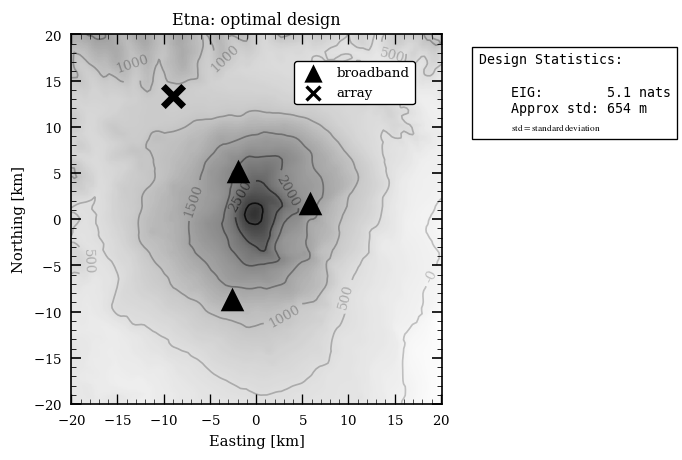

In [36]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

plot_topography(ax, SURFACE_DATA['topography'])
plot_design(ax, best_design)
eig, approx_std = plot_design_statistics(ax, best_design, nmc_method, prior_information)

ax.set_title(f'{VOLCANO_NAME}: optimal design')

plt.show()